This code is designed to retrieve surface information from input A-D image files and given instrument response parameters

In [49]:
# Generic imports
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import PIL
import copy
from scipy.interpolate import griddata
from scipy.special import gamma
import scipy.optimize as optimization
import os

# Reloading
from importlib import reload

# Local imports
import sys
sys.path.append('../../../')
import imagestuff as ims
import retrievestuff as rs
import f90nml
import gradstuff as gds
import statstuff as sts

In [50]:
%matplotlib notebook

In [51]:
# Specify the file we want to analyze (and output file name)
pwd = os.getcwd()
print(pwd)
startpos = pwd.find('crystals/')
case = pwd[startpos+9:]; print(case)
Segmentnamelistroot = 'Segments_Calibration'
imageroot = 'case3.0'
Calibrationfile = 'Calibration.nml'

/Users/Noah/Documents/GitHub/ice2021/crystals/2024-06-19/case3.0
2024-06-19/case3.0


In [52]:
# Derivative names
Compressedfilename = Segmentnamelistroot+'_retrieved.npz'; print (Compressedfilename)
Roughnessfile = Segmentnamelistroot+'_roughness.jpg'; print(Roughnessfile)
Roughnessdatafile = Segmentnamelistroot+'_roughness.txt'; print(Roughnessdatafile)

Segments_Calibration_retrieved.npz
Segments_Calibration_roughness.jpg
Segments_Calibration_roughness.txt


In [53]:
# These are derivative names
Segmentnamelist = Segmentnamelistroot+'.nml'
Segmentfile = Segmentnamelist
SEMSegmentjpgfile =  Segmentnamelistroot+'.jpg'
Retrievedjpgfile =   Segmentnamelistroot+'_retrieved.jpg'
Compressedfilename = Segmentnamelistroot+'_retrieved'

In [54]:
# Read the input dataset, including spacing in micrometers
dx,dy,cA,cB,cC,cD,Filename = ims.getc2('', 'SEMimages/', imageroot,'D')
print("Filename, dx and dy", Filename, dx, dy)

SEMimages/case3.0-A.bmp
SEMimages/case3.0-B.bmp
SEMimages/case3.0-C.bmp
SEMimages/case3.0-D.bmp
Filename, dx and dy SEMimages/case3.0-D.bmp 0.1803977 0.1803977


In [55]:
# Extract the desired segments
Segments=f90nml.read(Segmentfile) #reads the file at a given path
nysegments=Segments['Segments']['nysegments']
nxsegments=Segments['Segments']['nxsegments']
nacross=Segments['Segments']['nacross']
ndown=Segments['Segments']['ndown']
nxstart=Segments['Segments']['nxstart']
ny1start=Segments['Segments']['ny1start']
ny2start = ny1start+ndown 
nx1list = []; nx2list = []
ny1list = []; ny2list = []
for ix in range(nxsegments):
    nx1start = nxstart+ix*nacross; nx2start = nxstart+(ix+1)*nacross 
    for i in range(nysegments):
        nx1list.append(nx1start); nx2list.append(nx2start)
        ny1list.append(ny1start+i*ndown); ny2list.append(ny2start+i*ndown)
nsegments = nxsegments*nysegments

Benchmark score for random signals = 7.561703827490078
Correlation of detectors A-D for each segment
for segment  0
nx= 41
ny= 41
0 1 2.0879794007319834
0 2 0.3402819858604813
0 3 -1.7209718445679711
1 2 0.8278903478034689
1 3 3.4795740619470585
2 3 -5.309249823762468
Correlation score = 6.958316295574717



<IPython.core.display.Javascript object>


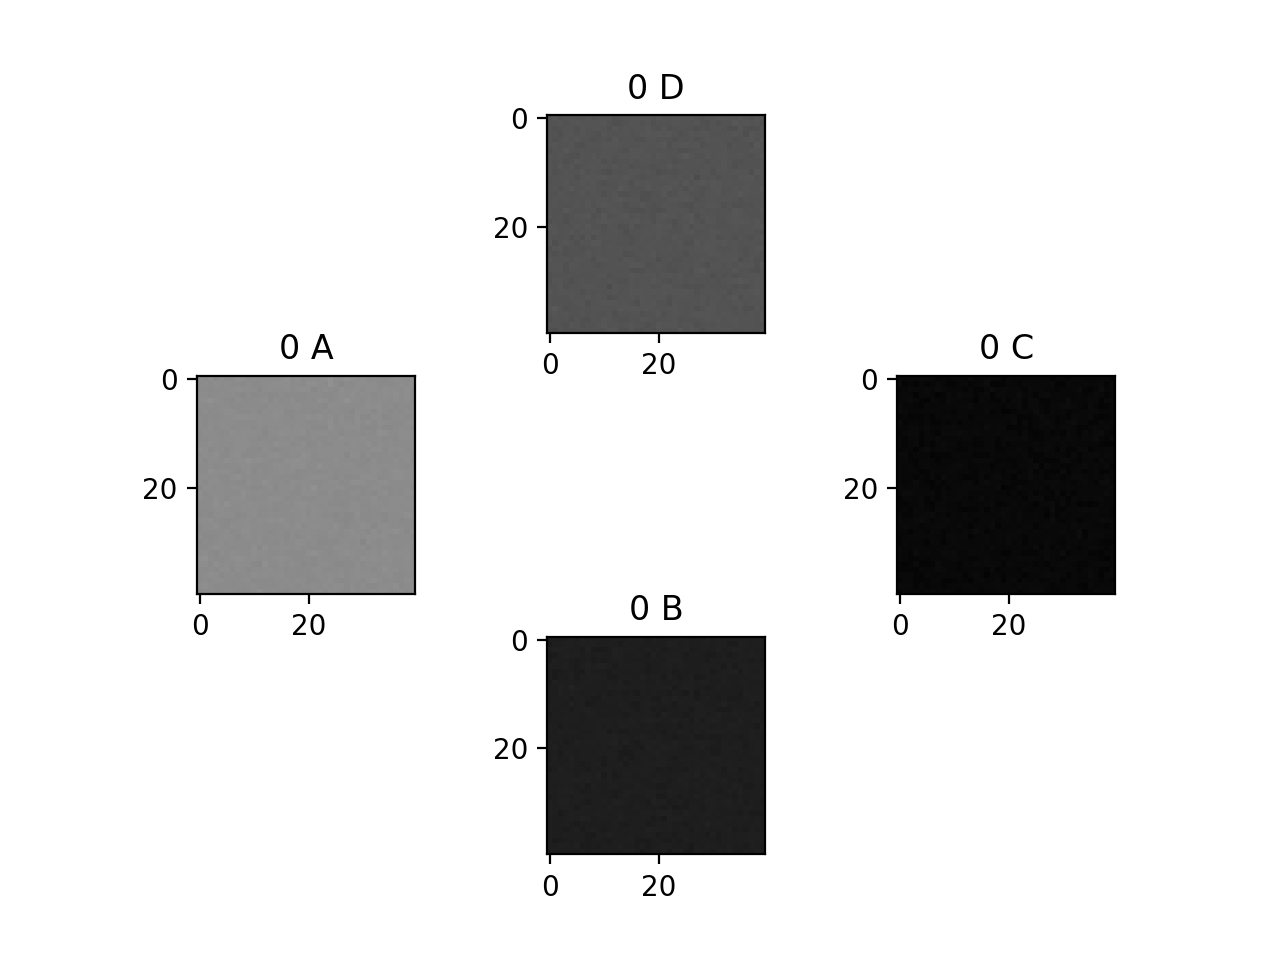

for segment  1
nx= 41
ny= 41
0 1 -2.1310000646867344
0 2 2.790507753704949
0 3 -4.503234397697275
1 2 24.929449568147035
1 3 -24.708130540380672
2 3 -41.790930634065575
Correlation score = 54.87311061596878



<IPython.core.display.Javascript object>


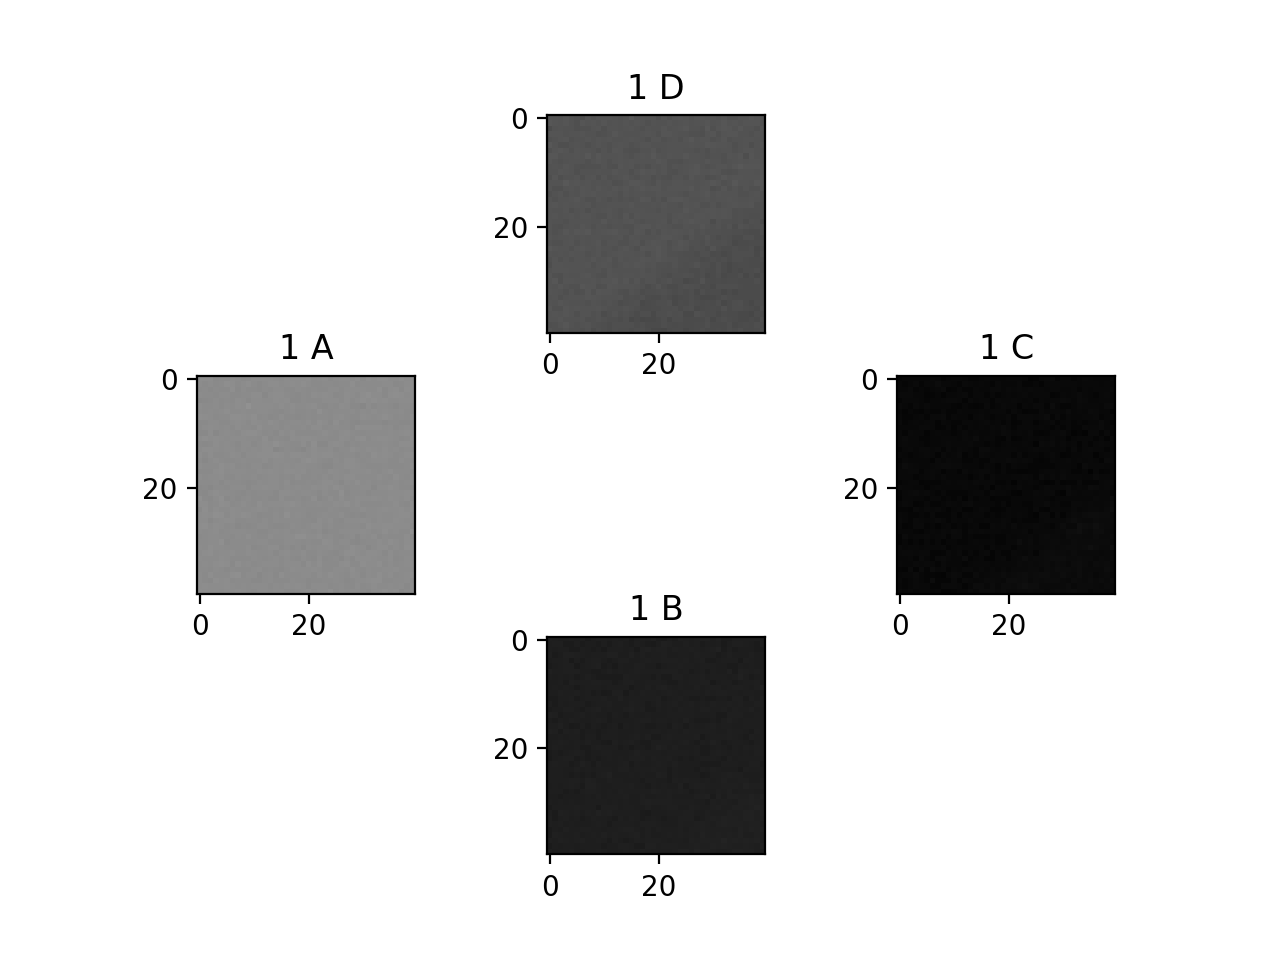

for segment  2
nx= 41
ny= 41
0 1 49.89475666953528
0 2 -12.346356038490097
0 3 -18.04299718488337
1 2 -27.20327405354875
1 3 -51.90734022643812
2 3 51.91655581308407
Correlation score = 95.379179353063



<IPython.core.display.Javascript object>


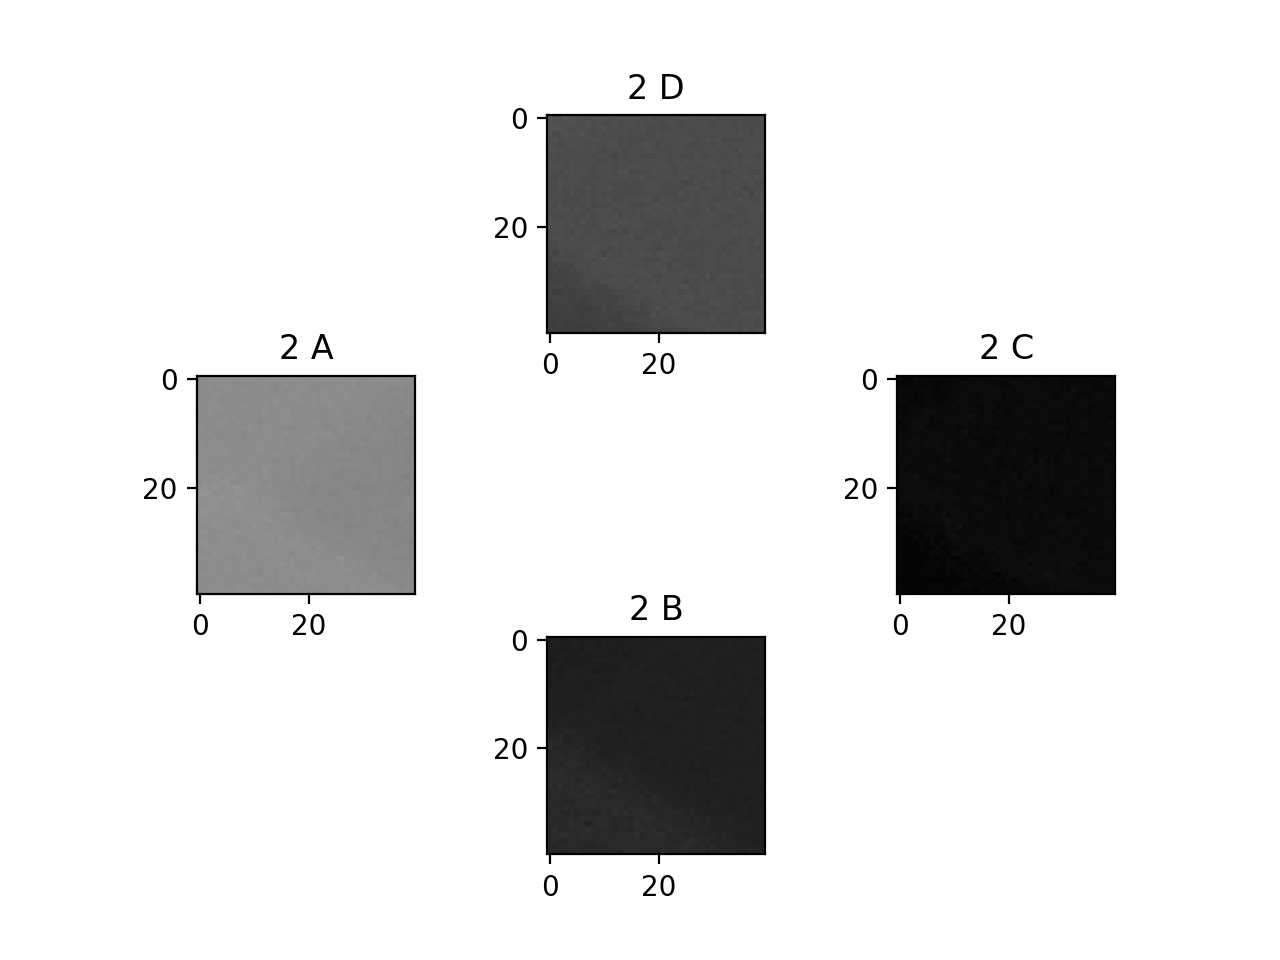

for segment  3
nx= 41
ny= 41
0 1 -2.98115290064911
0 2 6.789728685922205
0 3 6.1605266199181745
1 2 -13.89433708835735
1 3 -13.29154389088377
2 3 58.686597546611
Correlation score = 62.504193860942515



<IPython.core.display.Javascript object>


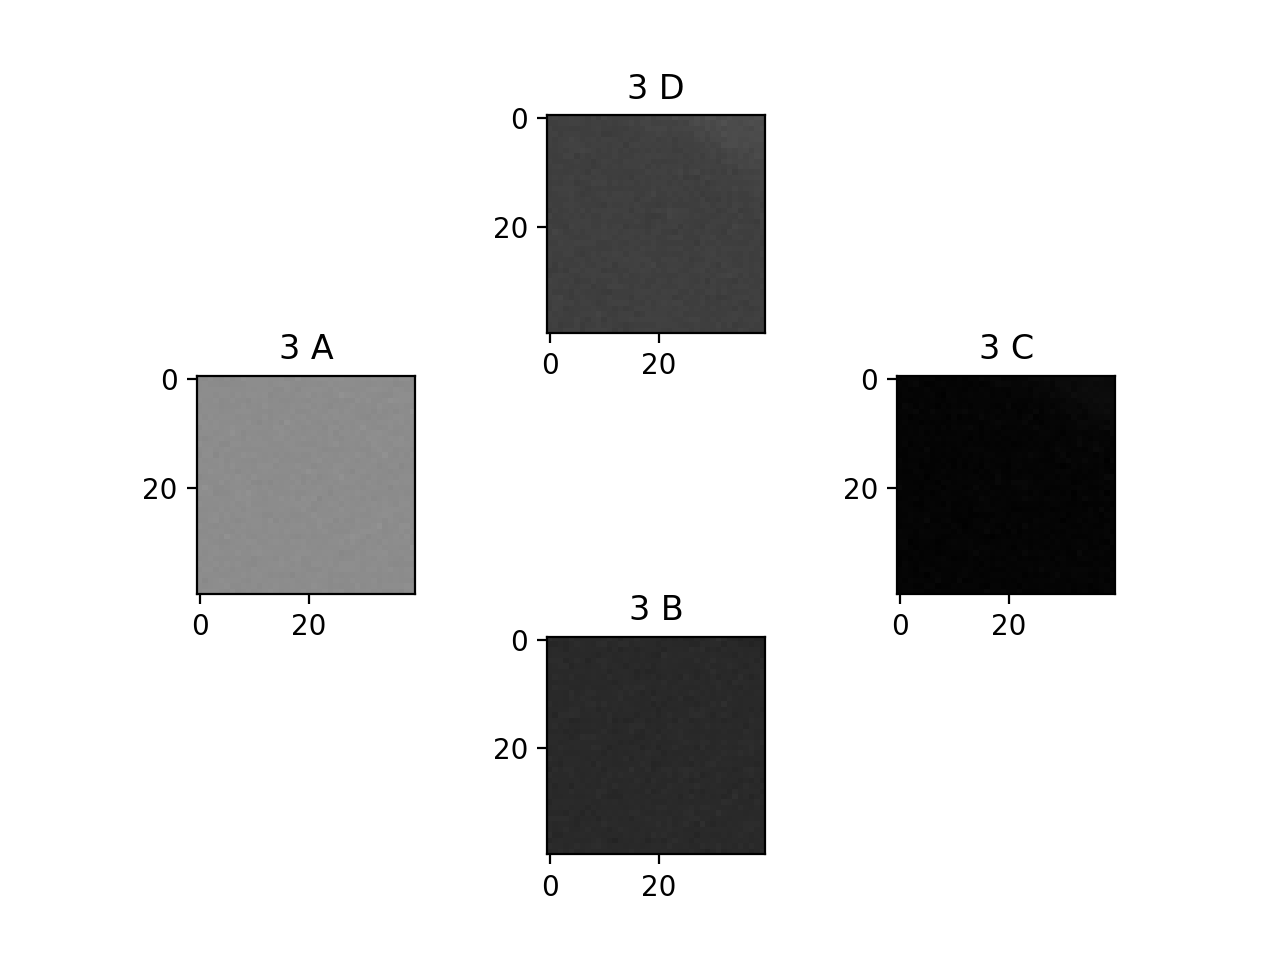

for segment  4
nx= 41
ny= 41
0 1 -0.42694226265983426
0 2 -0.47102483910839776
0 3 2.831972953332556
1 2 -0.7717370789514902
1 3 1.5760810690122145
2 3 -14.774887797834415
Correlation score = 15.159193052297768



<IPython.core.display.Javascript object>


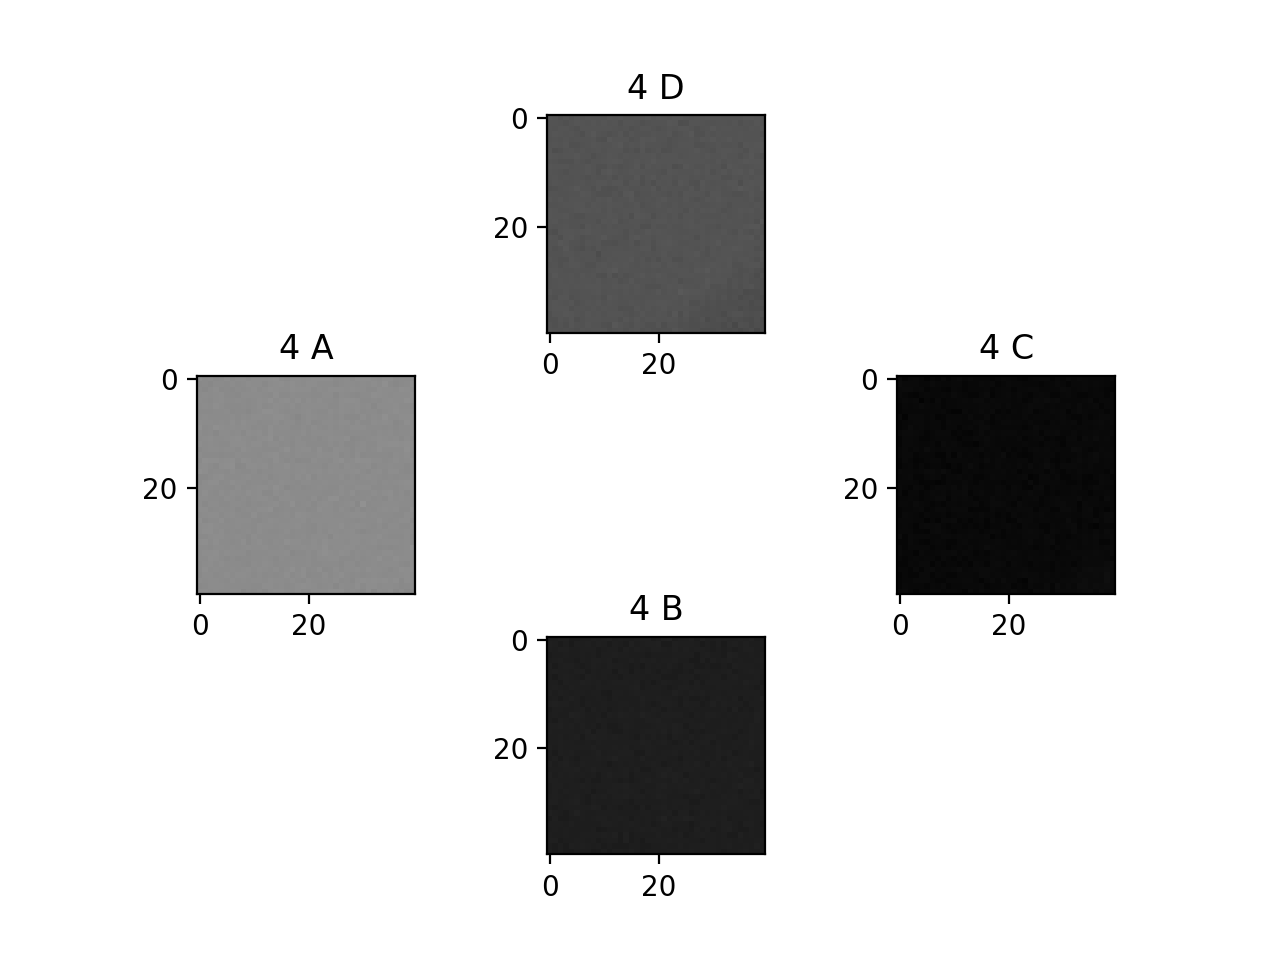

for segment  5
nx= 41
ny= 41
0 1 -17.561846159469674
0 2 -9.123127152533536
0 3 23.541951226249843
1 2 17.752222308248815
1 3 -33.09888008656639
2 3 -31.343669833712333
Correlation score = 57.783875394615556



<IPython.core.display.Javascript object>


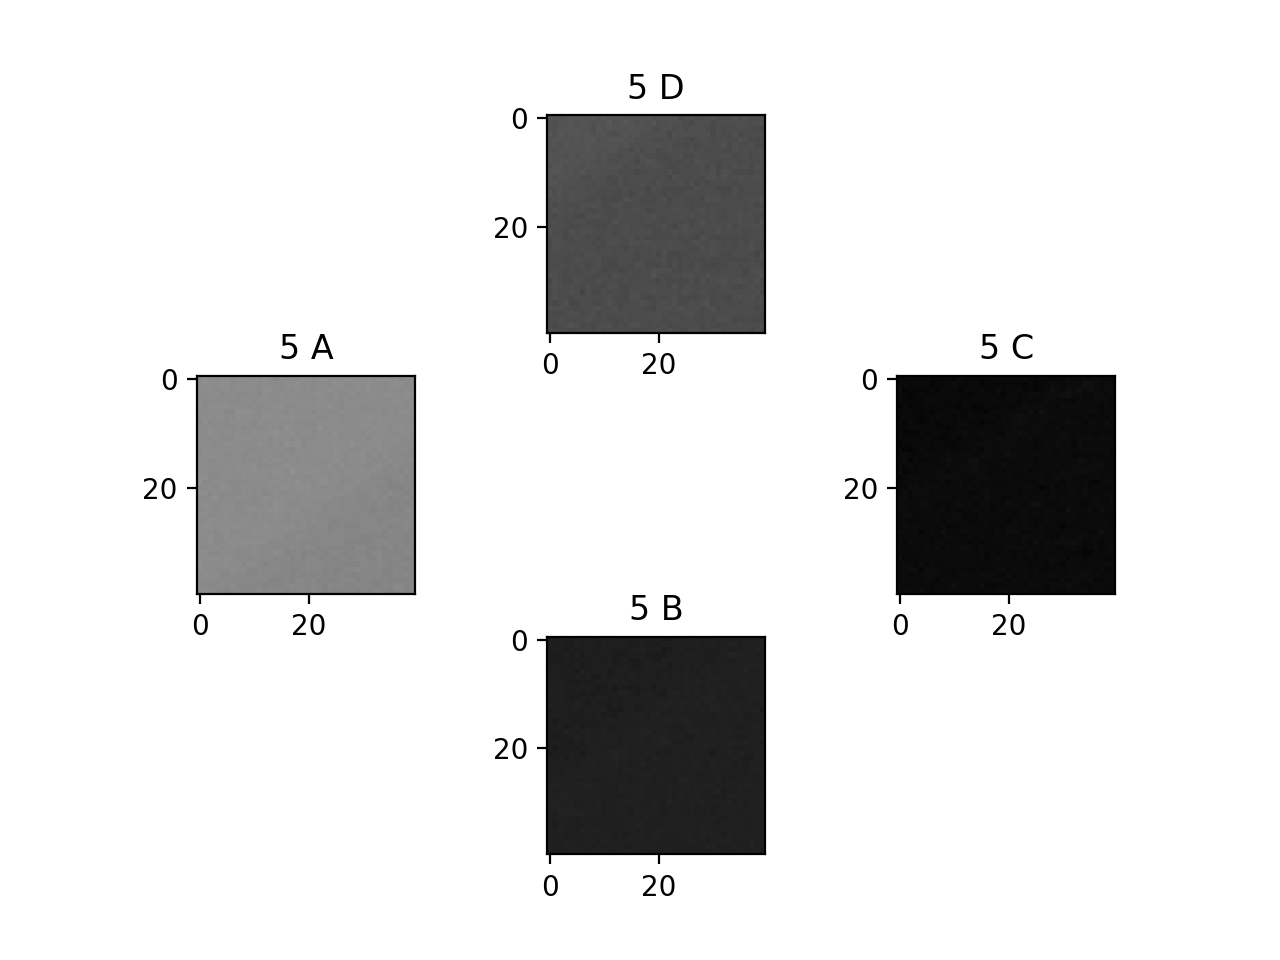

for segment  6
nx= 41
ny= 41
0 1 -0.15708545596060075
0 2 -0.7395842026033036
0 3 1.149780462919292
1 2 -2.560316576398414
1 3 -1.917042344314077
2 3 -3.5291441890113635
Correlation score = 4.957699746276694



<IPython.core.display.Javascript object>


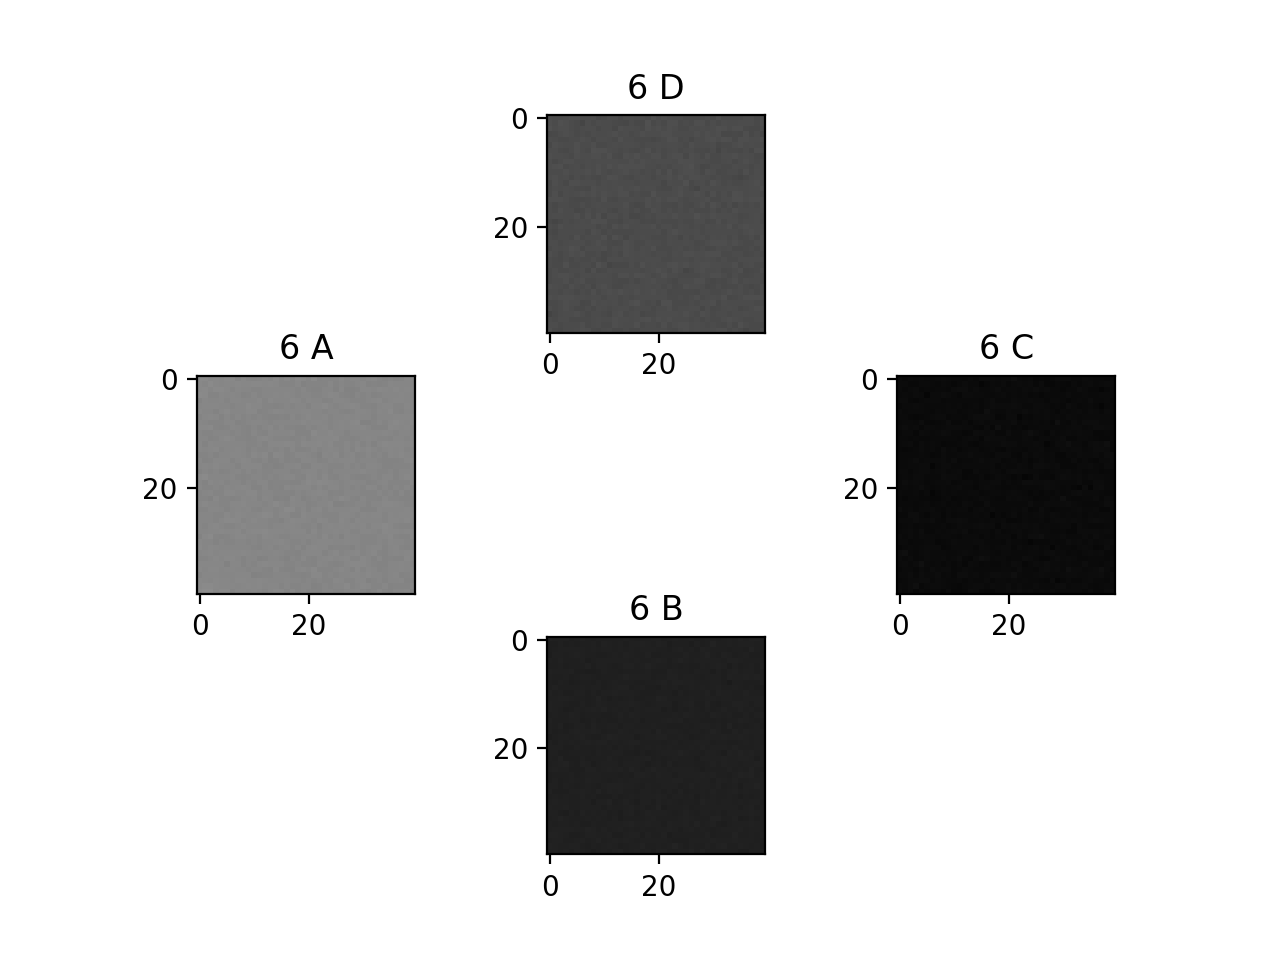

for segment  7
nx= 41
ny= 41
0 1 15.614006712687505
0 2 -43.951071567662865
0 3 -34.511506785555966
1 2 -38.392248130205346
1 3 -55.63656850086889
2 3 77.91964436156384
Correlation score = 118.3528683499258



<IPython.core.display.Javascript object>


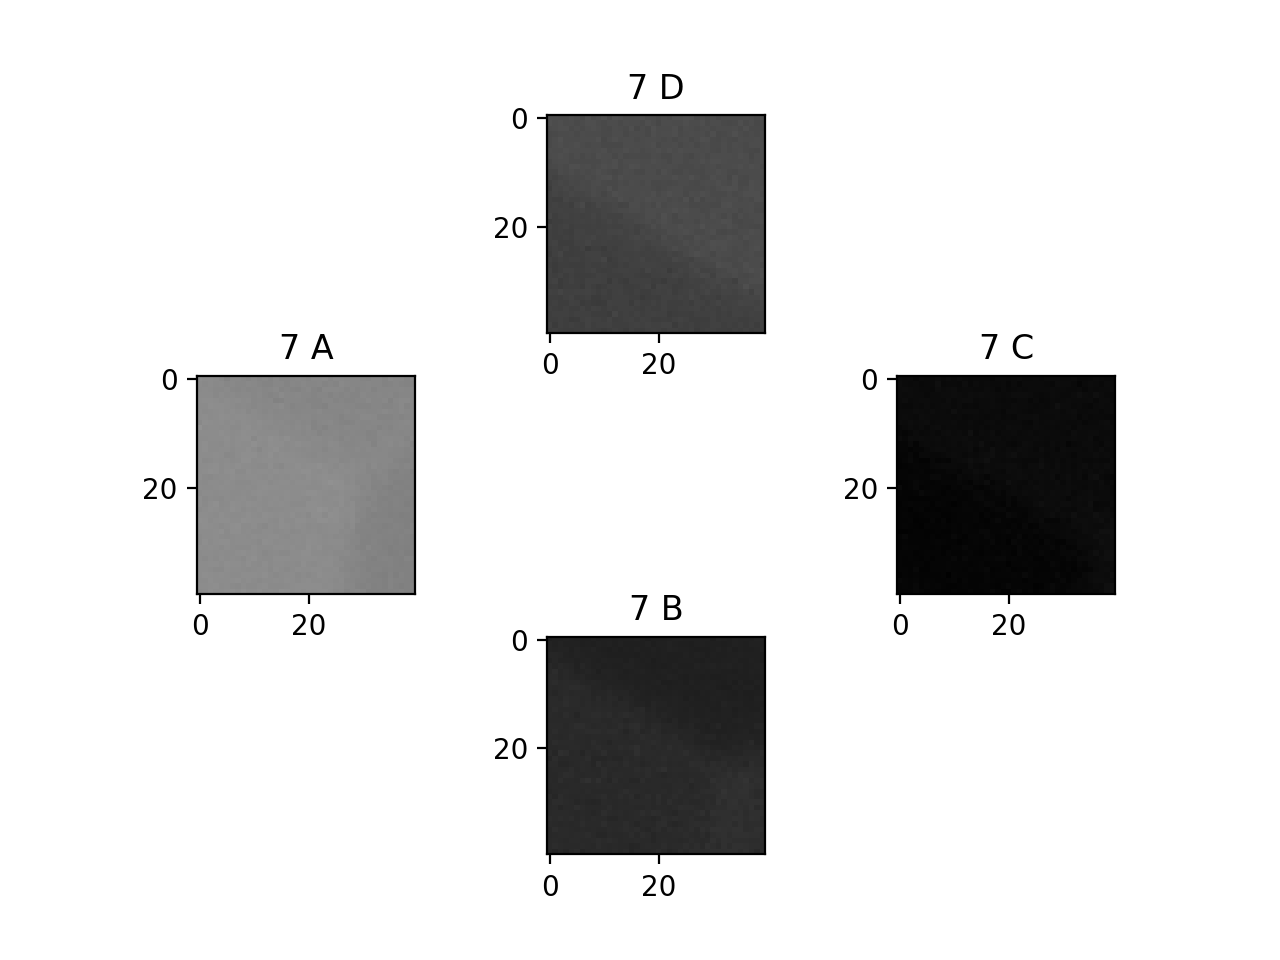

for segment  8
nx= 41
ny= 41
0 1 -17.40003974451109
0 2 -12.315633087307976
0 3 23.29301733400993
1 2 35.17899630971314
1 3 -44.24309269295706
2 3 -47.049519568252215
Correlation score = 80.03543703868928



<IPython.core.display.Javascript object>


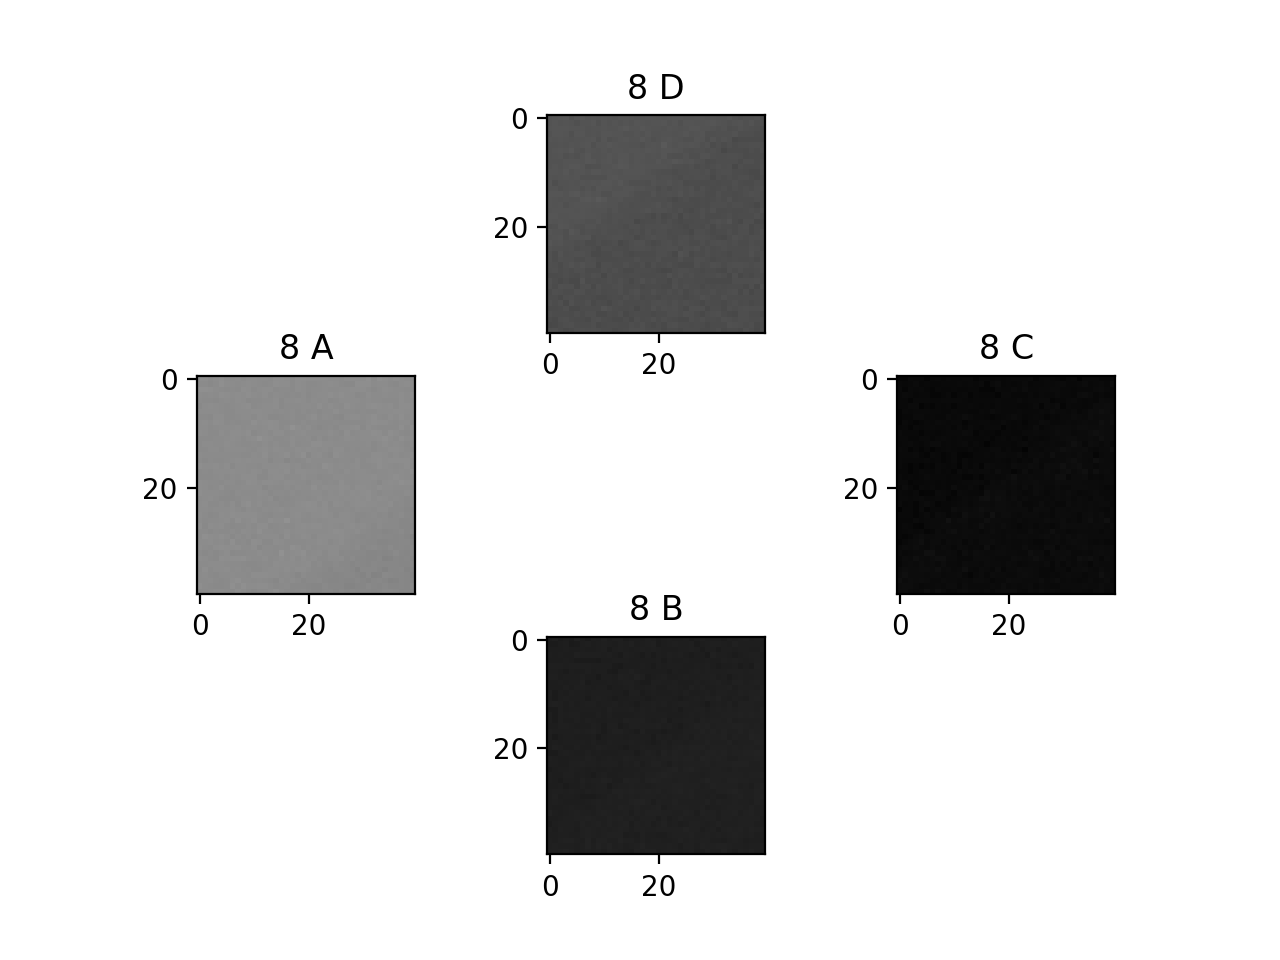

for segment  9
nx= 41
ny= 41
0 1 0.3763031632162498
0 2 -1.2912000654548932
0 3 1.716130355959089
1 2 0.9155156122488715
1 3 2.029303424444087
2 3 -5.870701840994114
Correlation score = 6.646449157926745



<IPython.core.display.Javascript object>


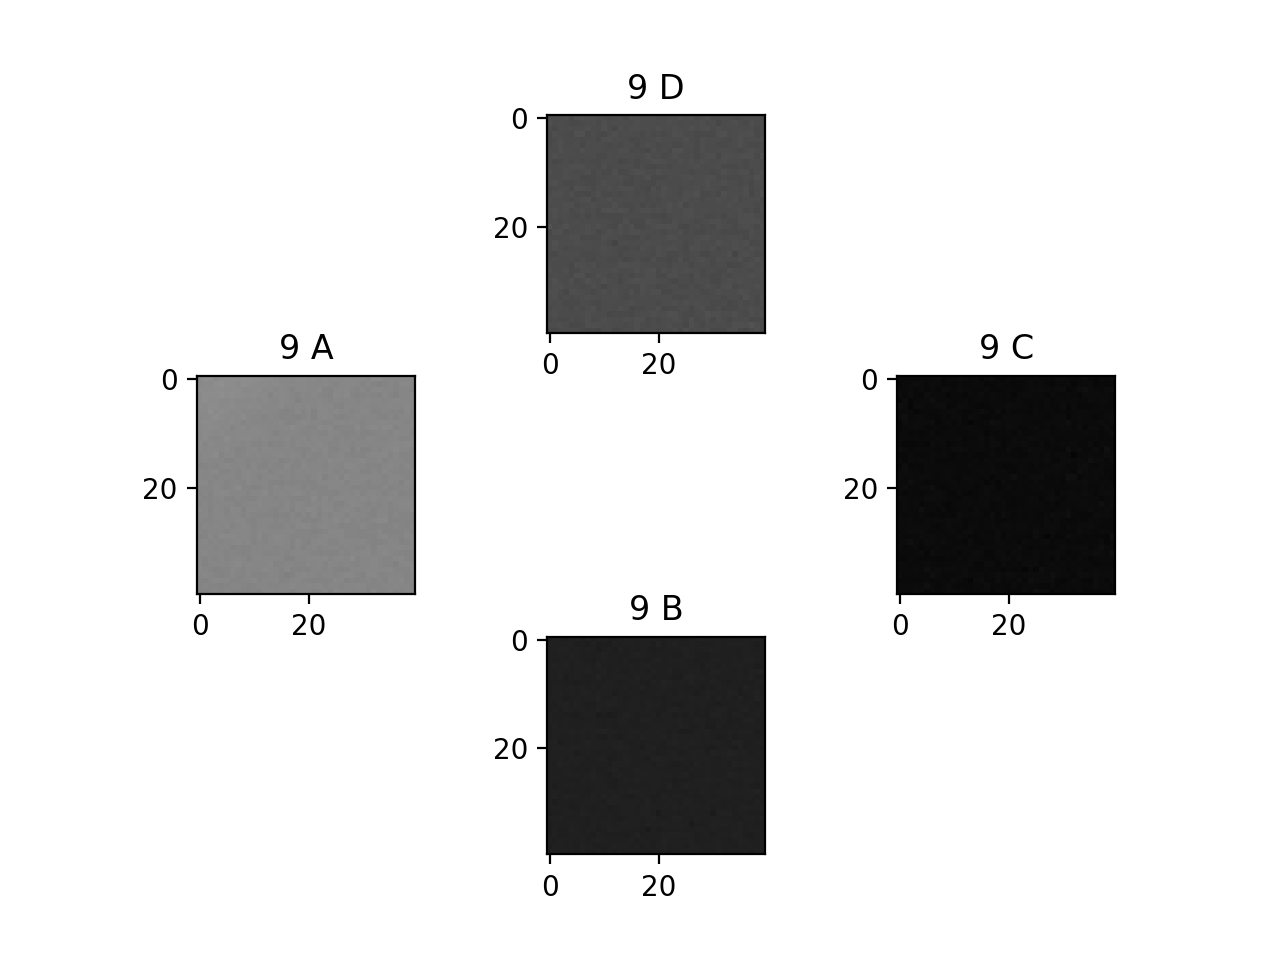

for segment  10
nx= 41
ny= 41
0 1 -46.372962058796475
0 2 -11.653584244350679
0 3 2.1906248878972625
1 2 16.437507071336736
1 3 -1.8439321042158932
2 3 -0.7442795266762154
Correlation score = 50.64782472708244



<IPython.core.display.Javascript object>


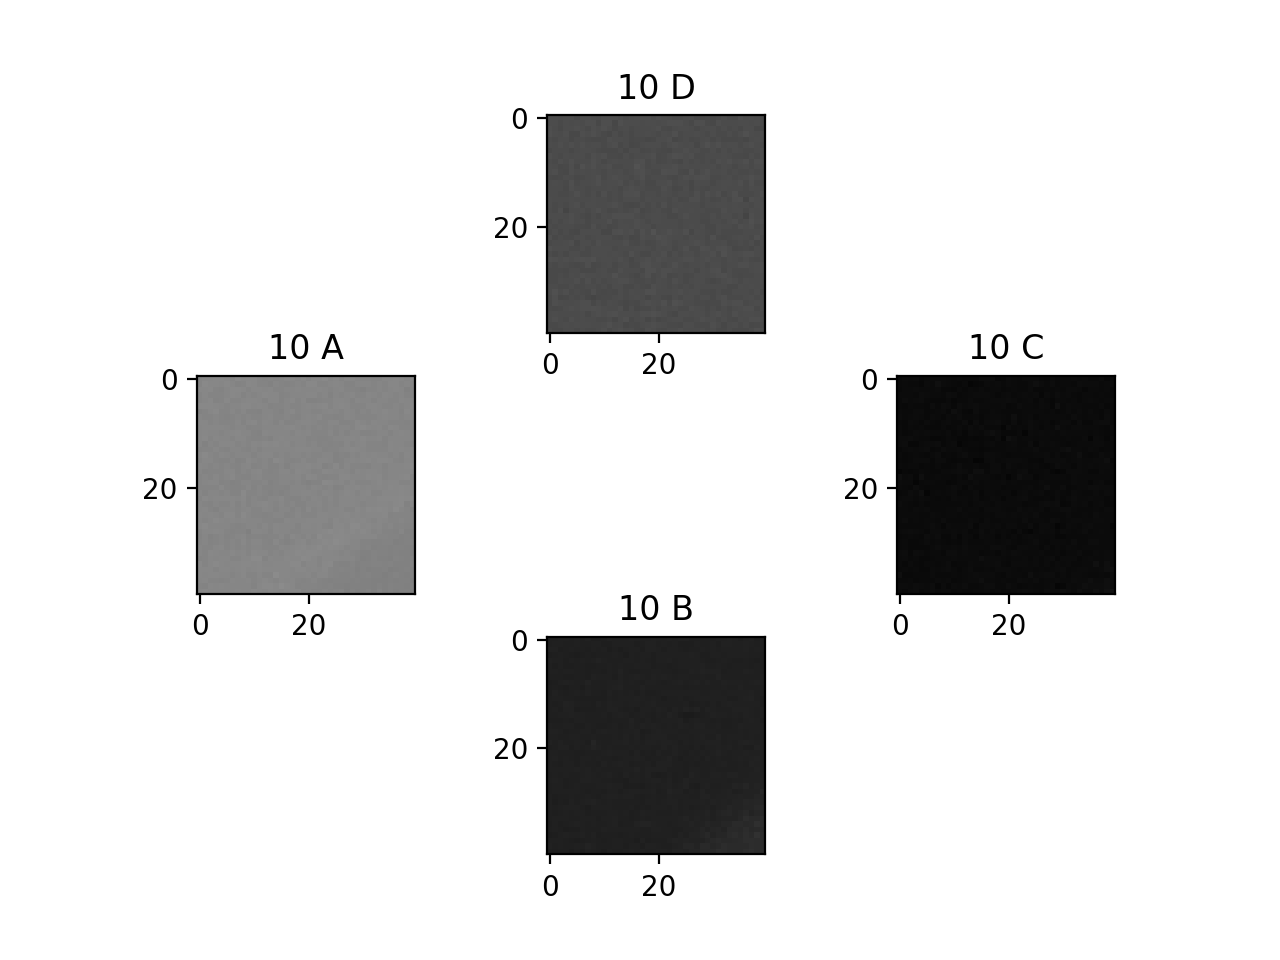

for segment  11
nx= 41
ny= 41
0 1 -62.429908922008956
0 2 -38.882822607354726
0 3 7.9273895808156425
1 2 59.165561015374756
1 3 -15.916904554557041
2 3 -23.44439503086992
Correlation score = 98.87245342721988



<IPython.core.display.Javascript object>


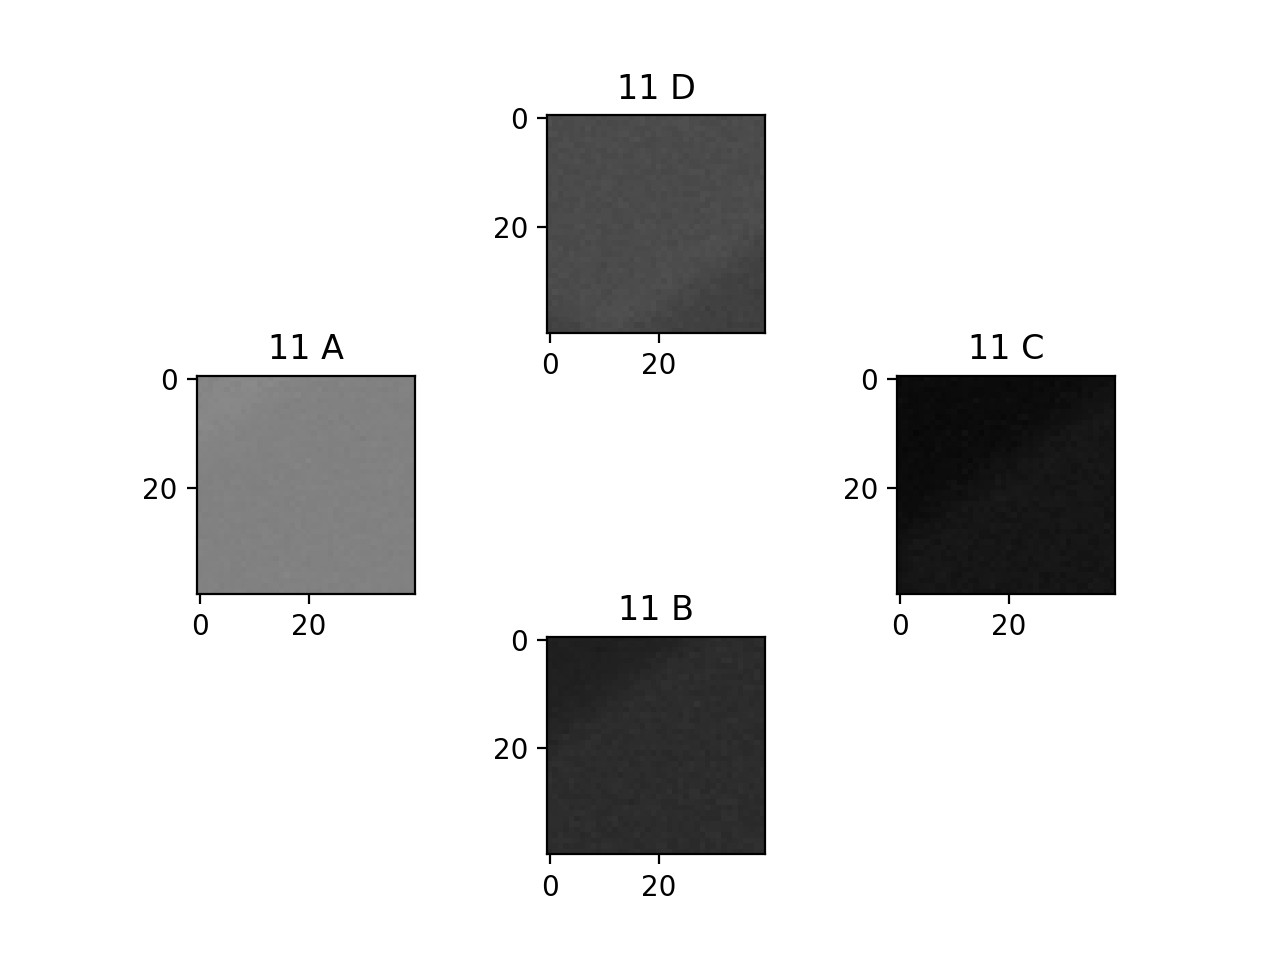

for segment  12
nx= 41
ny= 41
0 1 -9.246016585326892
0 2 0.7673045242263377
0 3 5.638504841441161
1 2 -1.4754987852942154
1 3 -3.0187426850318837
2 3 1.297998338080595
Correlation score = 11.438750785181561



<IPython.core.display.Javascript object>


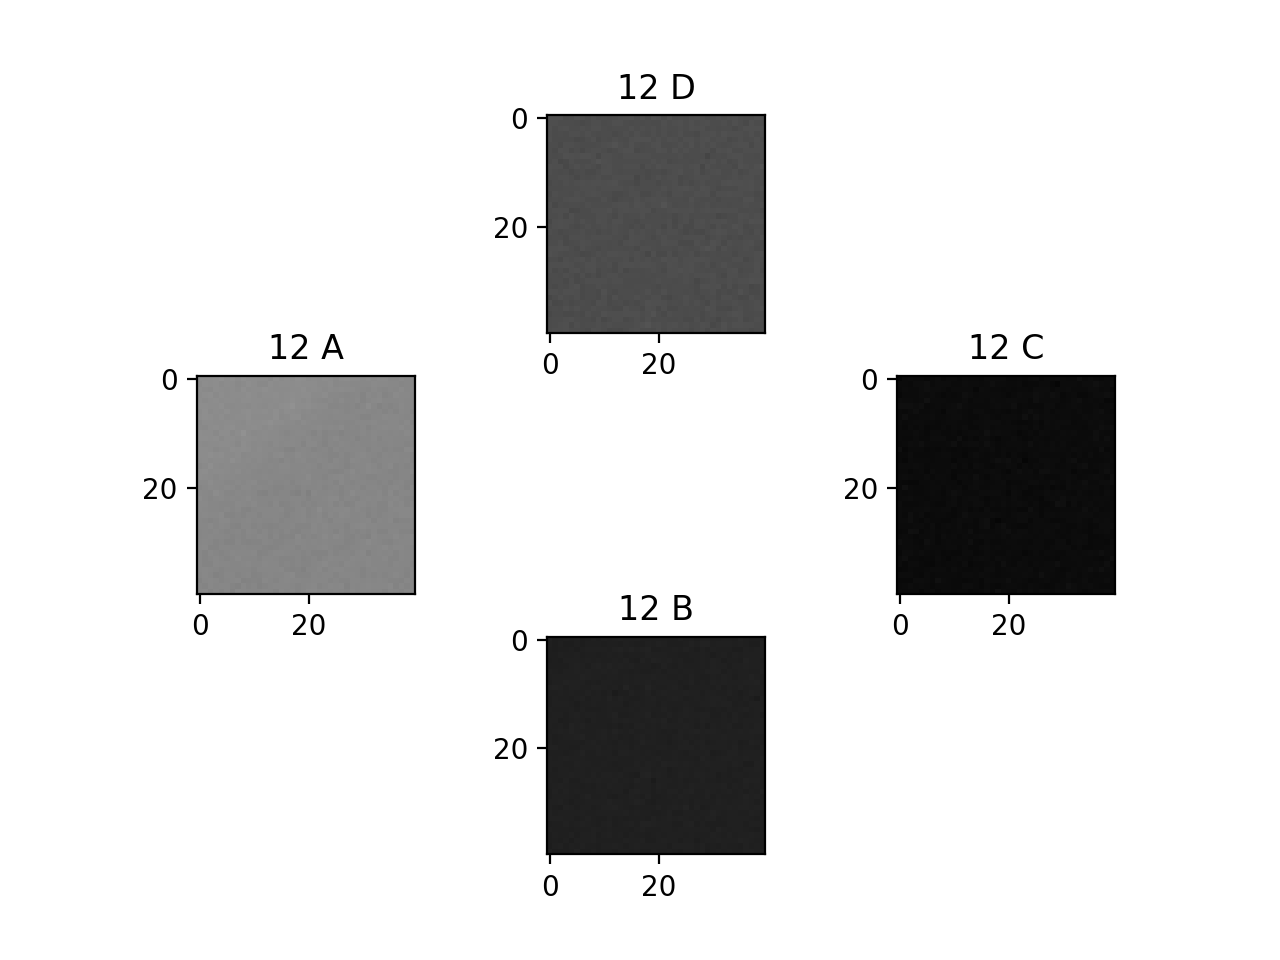

for segment  13
nx= 41
ny= 41
0 1 -7.37526102138183
0 2 -3.7486657108129755
0 3 -0.7154350026744588
1 2 -1.3219164109562744
1 3 -1.7775003528842914
2 3 0.7825917144783527
Correlation score = 8.63007747830924



<IPython.core.display.Javascript object>


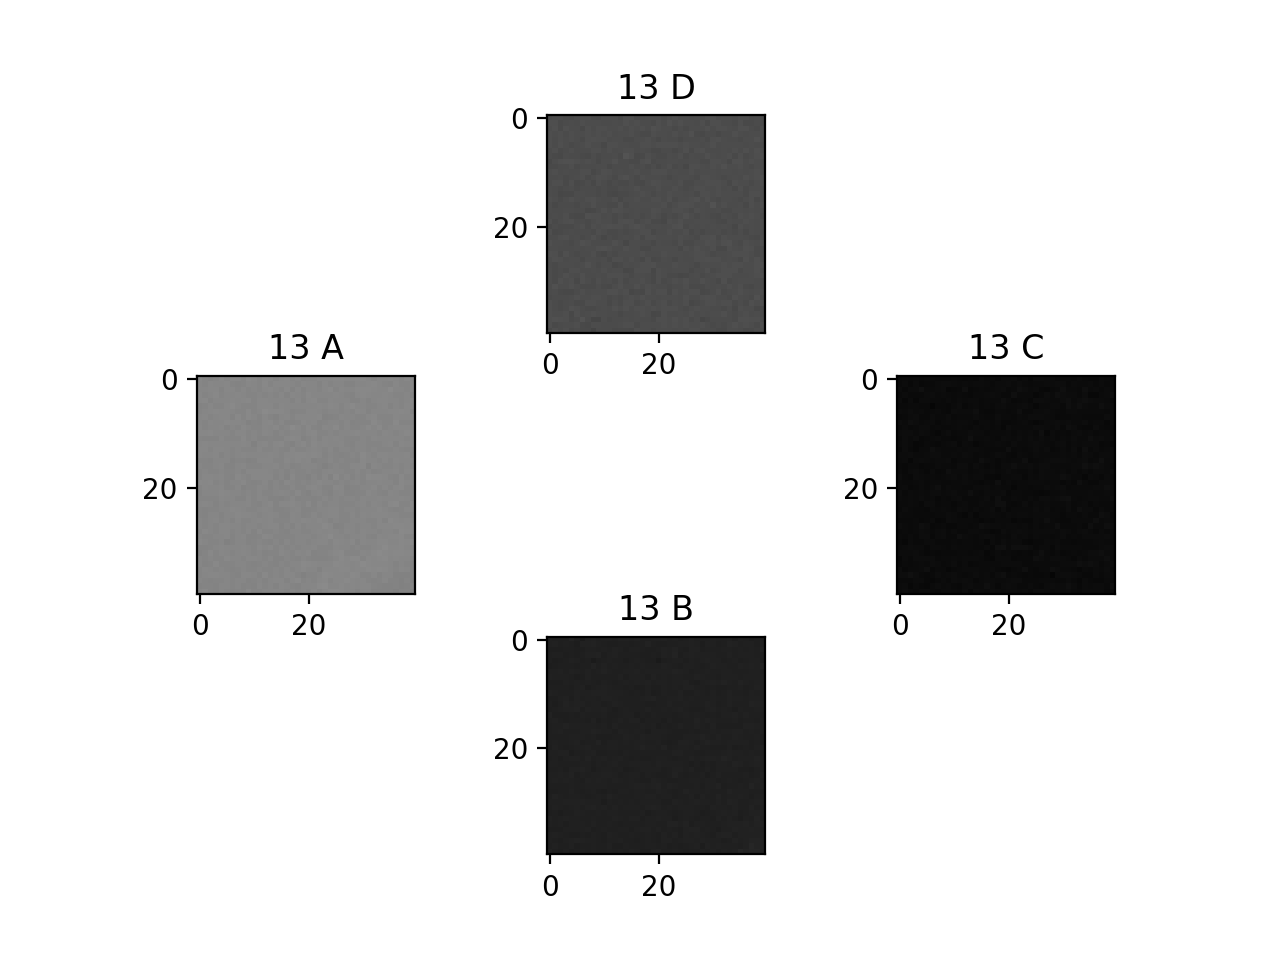

for segment  14
nx= 41
ny= 41
0 1 -74.18995954464306
0 2 -47.694833879639134
0 3 2.026981040970828
1 2 66.94824749098063
1 3 -7.0711838470023824
2 3 -5.640628023918216
Correlation score = 111.11679484127733



<IPython.core.display.Javascript object>


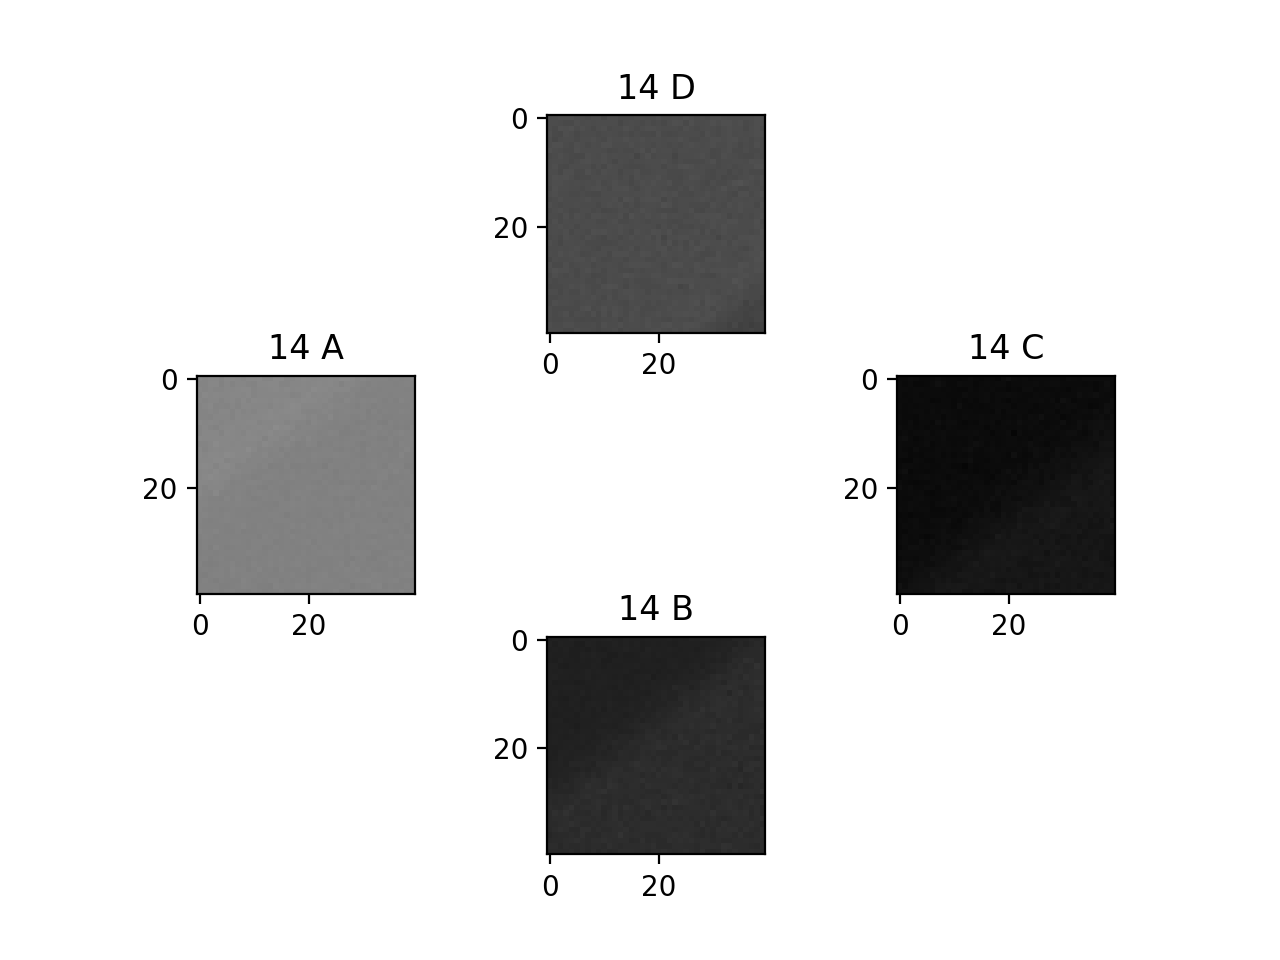

for segment  15
nx= 41
ny= 41
0 1 -2.48620174366303
0 2 -4.17600344472123
0 3 4.432234860392282
1 2 -1.2589229515043248
1 3 -5.085689090644263
2 3 -0.5053797723440001
Correlation score = 8.424336114911974



<IPython.core.display.Javascript object>


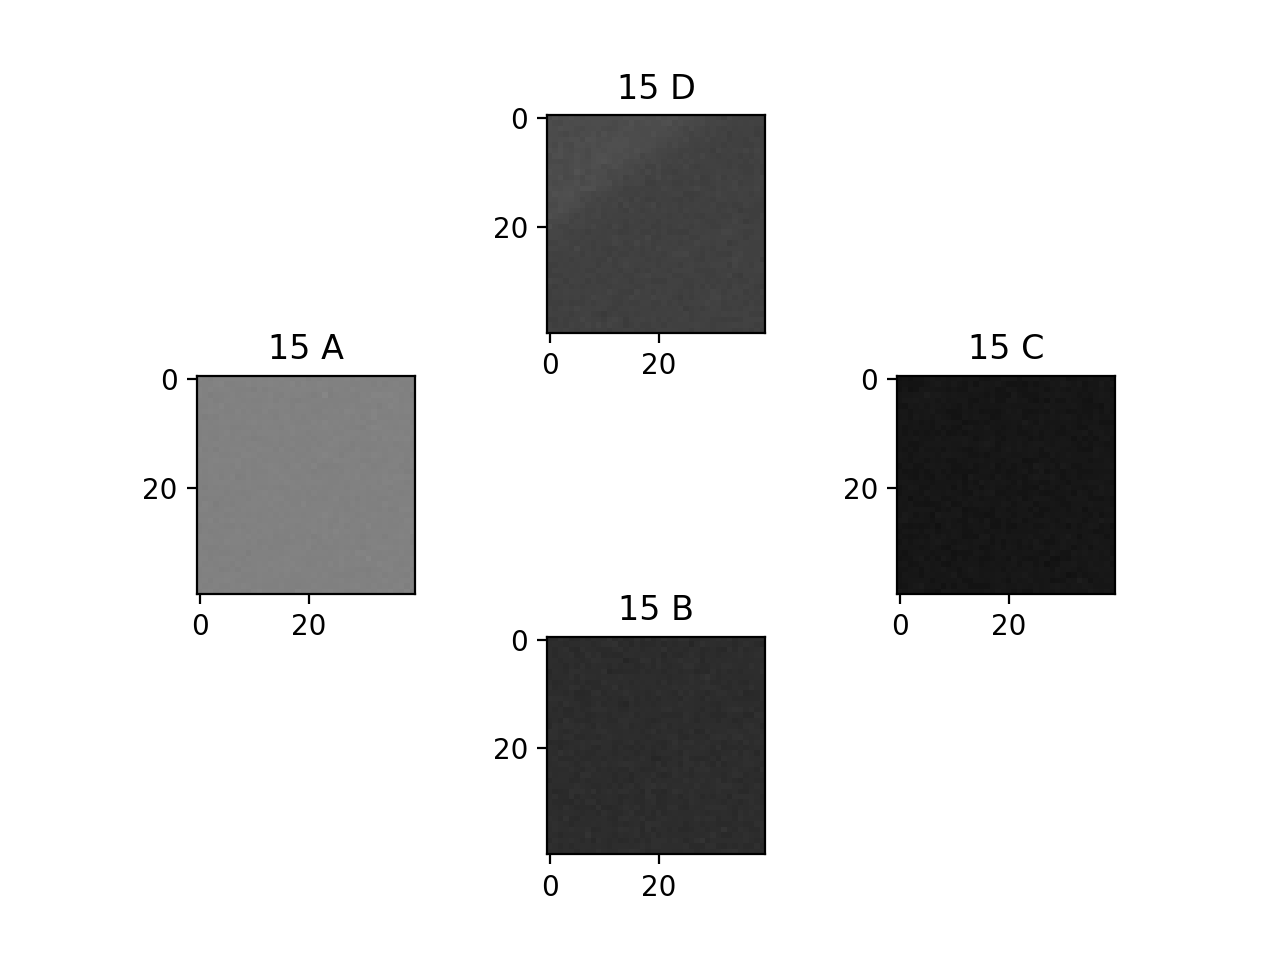

for segment  16
nx= 41
ny= 41
0 1 3.8640669844605124
0 2 10.754727824462242
0 3 10.10452884489679
1 2 -1.3985181232456094
1 3 0.05804472573650754
2 3 2.3901835804466134
Correlation score = 15.503834593270149



<IPython.core.display.Javascript object>


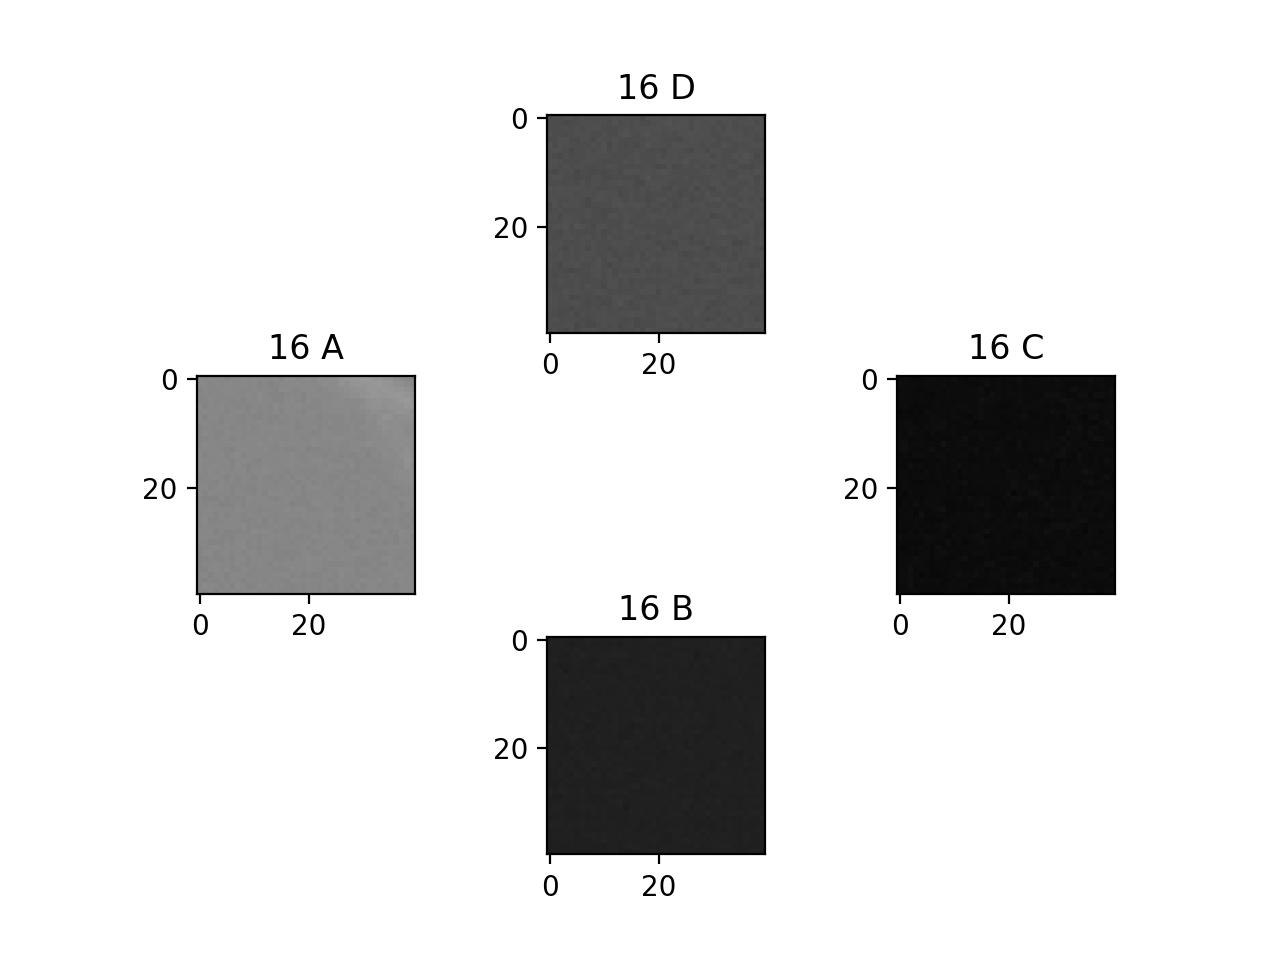

for segment  17
nx= 41
ny= 41
0 1 -75.98978996327448
0 2 -45.76596140983496
0 3 2.134847914792976
1 2 64.89238762773142
1 3 1.0175059850954282
2 3 5.740167281620035
Correlation score = 110.0842213440546



<IPython.core.display.Javascript object>


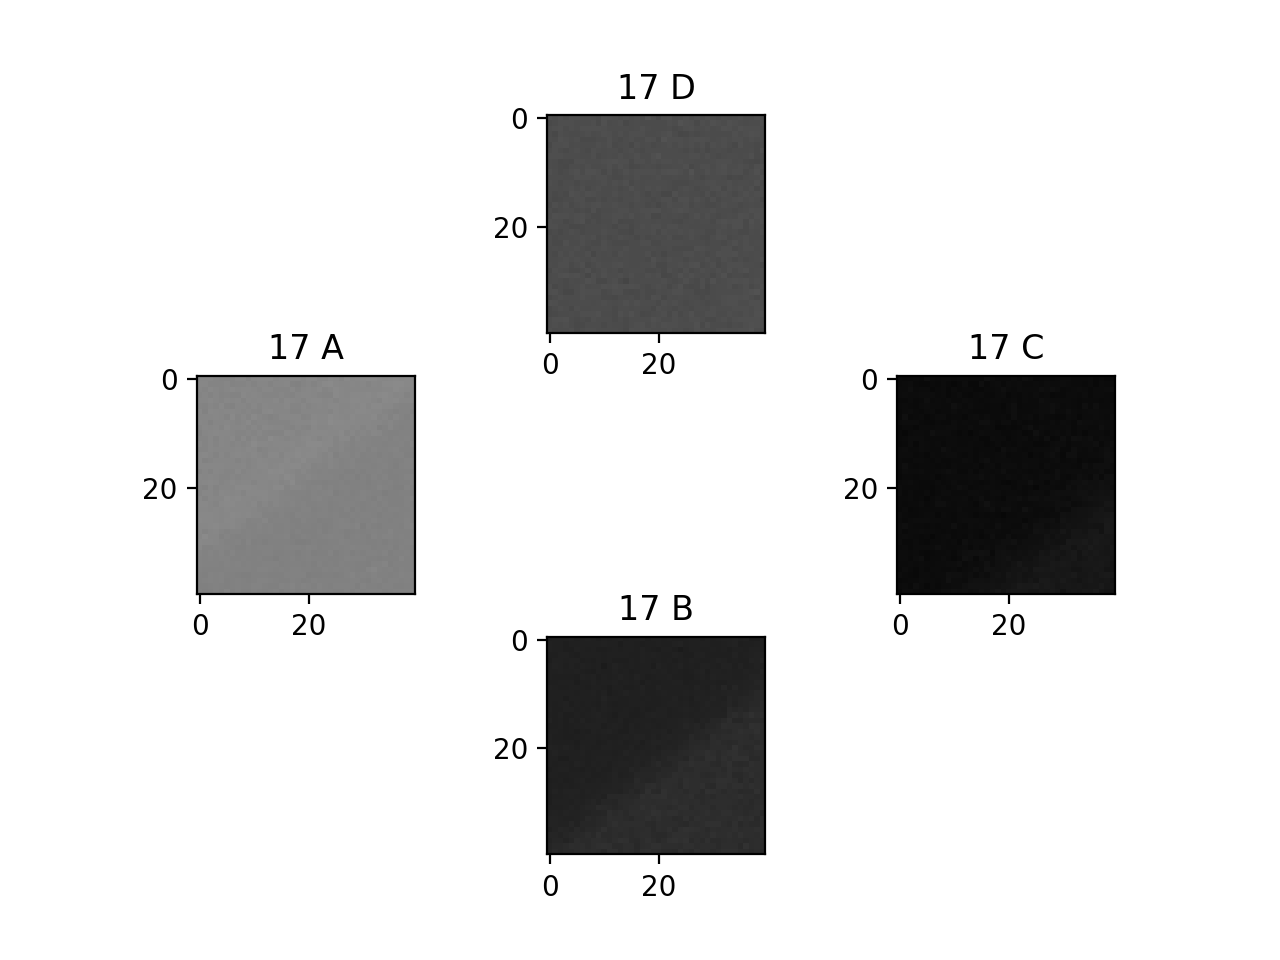

for segment  18
nx= 41
ny= 41
0 1 -6.766745738693228
0 2 4.535654522967398
0 3 -1.4471364331278034
1 2 1.8955833051564495
1 3 -5.820113427871889
2 3 -20.633212045224006
Correlation score = 23.057571628061417



<IPython.core.display.Javascript object>


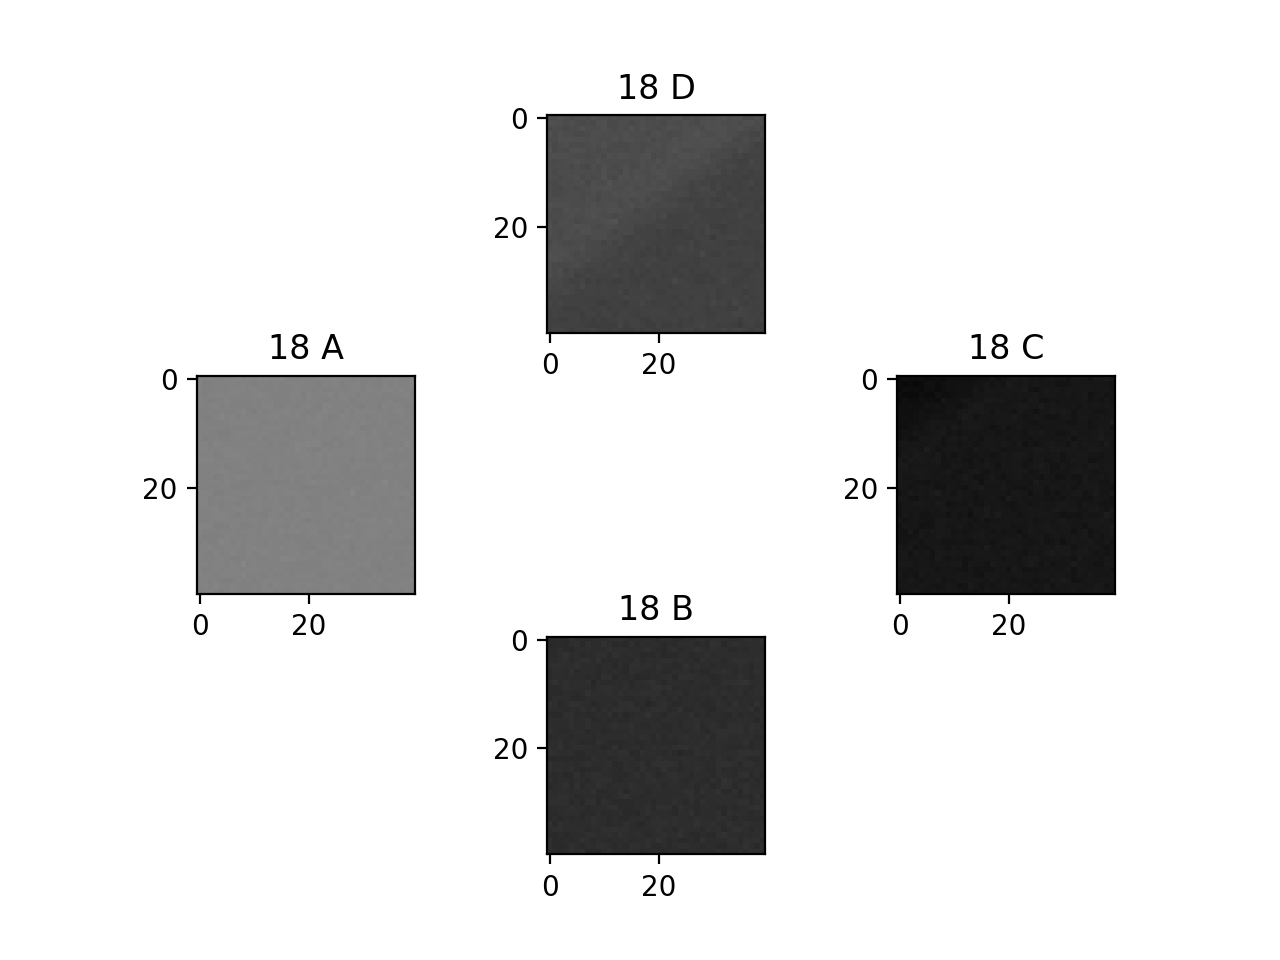

for segment  19
nx= 41
ny= 41
0 1 3.261926746715012
0 2 2.043190732812849
0 3 -3.747026437708676
1 2 -3.9598611763247664
1 3 -4.82627840548869
2 3 -2.523345465106922
Correlation score = 8.613694777260287



<IPython.core.display.Javascript object>


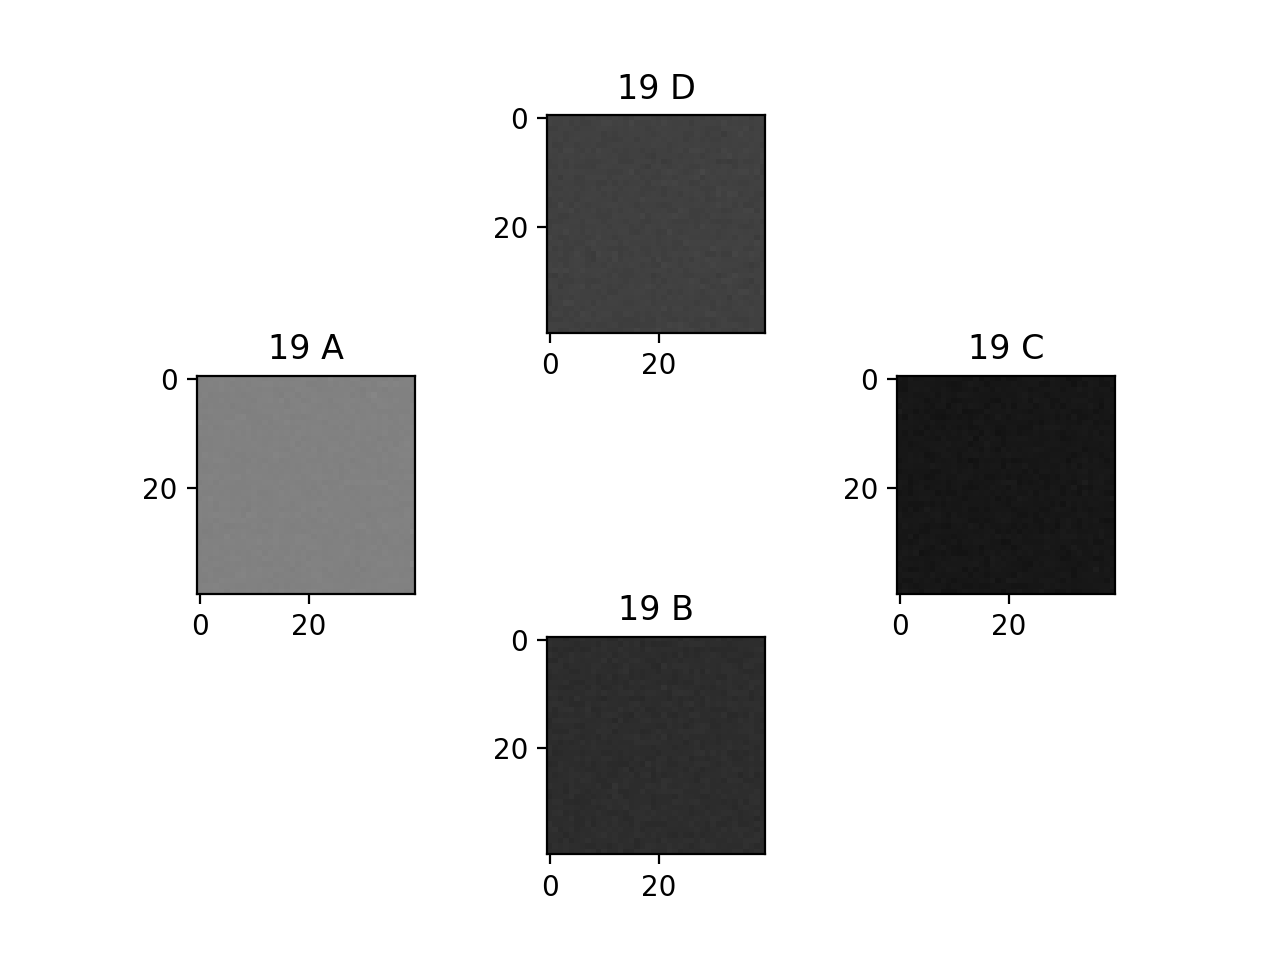

/var/folders/gr/80_rmzks0tx46b0crbcqt33r0000gn/T/ipykernel_51294/3074375444.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<IPython.core.display.Javascript object>


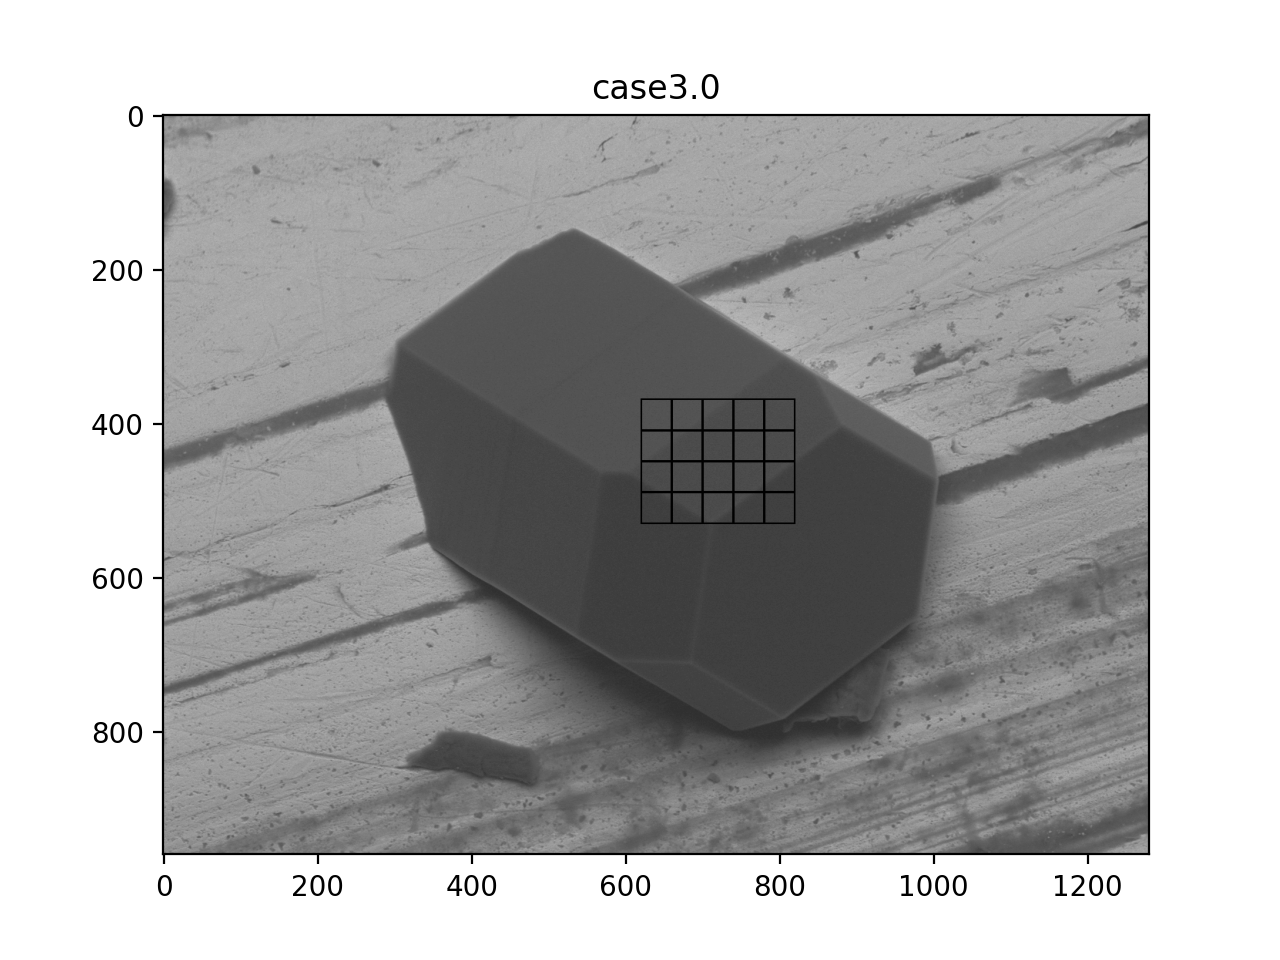

In [56]:
# Display
im = PIL.Image.open(Filename)

# Set up sub-grids in case of multiple segments
nyxgrid = []
for i in range(nsegments):
    nyxgridi = [ (y, x) for y in range(ny1list[i], ny2list[i]+1) for x in range(nx1list[i], nx2list[i]+1) ]
    nyxgrid.append(nyxgridi)

# Add the segments to the image
draw = PIL.ImageDraw.Draw(im)
for i in range(nsegments):
    nx1 = nx1list[i]
    nx2 = nx2list[i]
    ny1 = ny1list[i]
    ny2 = ny2list[i]
    ims.myrectangle(draw,(nx1,ny1),(nx2,ny2),5)

# What's the random expectation of information content
print('Benchmark score for random signals =', sts.randomcorrelation(nacross,ndown)*100*3)
    
# Loop to evaluate the information content in each segment
print('Correlation of detectors A-D for each segment')
for isegment in range(nsegments):
    
    print('for segment ', isegment)
    nx1=nx1list[isegment]; nx2=nx2list[isegment]; nx = nx2-nx1+1; print('nx=',nx)
    ny1=ny1list[isegment]; ny2=ny2list[isegment]; ny = ny2-ny1+1; print('ny=',ny)
    cAseg = cA[ny1:ny2,nx1:nx2]; #cAsegmean = np.mean(cAseg); print('<cA> =',cAsegmean)
    cBseg = cB[ny1:ny2,nx1:nx2]; #cBsegmean = np.mean(cBseg); print('<cB> =',cBsegmean)
    cCseg = cC[ny1:ny2,nx1:nx2]; #cCsegmean = np.mean(cCseg); print('<cC> =',cCsegmean)
    cDseg = cD[ny1:ny2,nx1:nx2]; #cDsegmean = np.mean(cDseg); print('<cD> =',cDsegmean)
    cseg = [cAseg,cBseg,cCseg,cDseg]
    infoscore = sts.getinfoscore(cseg)
    print('Correlation score =', infoscore)
    print('')

    # Show what the detectors see
    plt.figure()
    plt.subplot(334); plt.imshow(np.asarray(cAseg), cmap = 'Greys_r', vmin = 0, vmax = 255); plt.title(str(isegment)+' A')
    plt.subplot(338); plt.imshow(np.asarray(cBseg), cmap = 'Greys_r', vmin = 0, vmax = 255); plt.title(str(isegment)+' B')
    plt.subplot(336); plt.imshow(np.asarray(cCseg), cmap = 'Greys_r', vmin = 0, vmax = 255); plt.title(str(isegment)+' C')
    plt.subplot(332); plt.imshow(np.asarray(cDseg), cmap = 'Greys_r', vmin = 0, vmax = 255); plt.title(str(isegment)+' D')

# Show it
plt.figure()
plt.imshow(np.asarray(im), cmap = 'Greys_r', vmin = 0, vmax = 255)
plt.title(imageroot)

# Save a copy
im.save(SEMSegmentjpgfile)

In [57]:
# Read and unpack the calibration data

# Just echo input data files  
print(Calibrationfile)

# Extract
Calibration=f90nml.read(Calibrationfile) #reads the file at a given path
pA=Calibration['Calibration']['pA']
pB=Calibration['Calibration']['pB']
pC=Calibration['Calibration']['pC']
pD=Calibration['Calibration']['pD']

Calibration.nml


In [58]:
# Set up a grid of surface normal vectors and the backscatter response on them
nptsx = 103
nptsy = 101
nxmid = int(nptsx/2); #print nxmid
nymid = int(nptsy/2); #print nymid
nmax = 5
nxi = np.linspace(-nmax,nmax,nptsx); dnx = nxi[1]-nxi[0]
nyi = np.linspace(-nmax,nmax,nptsy); dny = nyi[1]-nyi[0]
nxigrid,nyigrid = np.meshgrid(nxi,nyi)
theta = 15*np.pi/180
sA = (-nxigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sB = (-nyigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sC = (+nxigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5
sD = (+nyigrid*np.sin(theta)+np.cos(theta)-1)/(1+nxigrid**2+nyigrid**2)**.5

# Set up the grids     
BSgridA = np.polyval(pA,sA)
BSgridB = np.polyval(pB,sB)
BSgridC = np.polyval(pC,sC)
BSgridD = np.polyval(pD,sD)

In [59]:
# Generating the response function for each detector
BSgridN = [BSgridA, BSgridB, BSgridC, BSgridD]
BSgridL = ['A', 'B', 'C', 'D']
BSmax = 150 # this for display purposes
nxigrid.shape

(101, 103)

In [60]:
# Set up interpolators for detector responses
Arule, Brule, Crule, Drule, \
KAxrule, KAyrule, KBxrule, KByrule, KCxrule, KCyrule, KDxrule, KDyrule =\
rs.setupdetectorresponse2(BSgridA, BSgridB, BSgridC, BSgridD, nxi, nyi, dnx, dny)

In [61]:
# Create a blank slate
solution = np.zeros(cA.shape)

In [62]:
# Generic retrieval parameters
maxiter = 5
tolerance = 10

In [63]:
# Create the a priori/solution set, and the uncertainty set
    
# Define the variance in the observations (BS units^2)
#noiseamp = 5.0
noiseamp = 25.0
print('Std deviation in input signal is', noiseamp**.5)

# Define parameters determining the variance in the a priori (microns^2)
apriorivar0 = 225.0

print('Std deviation in a priori is', apriorivar0**.5)

# Create the initial a priori variance
apriorivar = np.ones(cA.shape)*apriorivar0

# Create the initial a priori set
aprioriset = np.zeros(cA.shape)

Std deviation in input signal is 5.0
Std deviation in a priori is 15.0


In [64]:
# Loop to retrieve each segment
reload(rs)
for isegment in range(nsegments):
    
    # Choose the particular location of the dataset to analyze
    nx1=nx1list[isegment]; nx2=nx2list[isegment]; nx = nx2-nx1+1
    ny1=ny1list[isegment]; ny2=ny2list[isegment]; ny = ny2-ny1+1

    # Construct gradients
    Ny_unscaled, Nx_unscaled = gds.makeNxNy(ny,nx)
    Ny = Ny_unscaled/dy
    Nx = -Nx_unscaled/dx #fixing x inversion
    
    # Number of observations
    nobs = (nx-1)*(ny-1)*4

    # Number of desired points (heights)
    nzpts = ny*nx-1
    
    # Extract the a priori variance
    vartemp = apriorivar[ny1:ny2+1,nx1:nx2+1]
    #vartemp_long = np.reshape(vartemp,nzpts+1,0) # This appears to have been deprecated
    vartemp_long = vartemp.flatten(order='C')
    Sa = np.diag(vartemp_long[:-1]); #print "apriorivar", shape(Sa)
    
    # Extract the starting z
    settemp = solution[ny1:ny2+1,nx1:nx2+1]
    #settemp_long = np.reshape(settemp,nzpts+1,0)
    settemp_long = settemp.flatten(order='C')
    settemp_longminus1 = settemp_long[:-1]
    z_start = np.matrix(settemp_longminus1).T; #print "aprioriset", shape(z_start)
    z_start = z_start*0.0; #print "aprioriset", shape(z_start)

    # Construct the variance in observation + model
    Se = np.matrix(np.eye(nobs))*noiseamp # Variance in observation + model (c)

    # Do the retrieval
    print('')
    print("Segment:", isegment, '(', isegment+1, "of", nsegments, ')')
    print("for", nx1, ny1)
    z_retrieved = rs.retrievesegment(\
        nx1,ny1,nx2,ny2,cA,cB,cC,cD,\
        Sa,Se,z_start,maxiter,tolerance,\
        Nx,Ny,\
        Arule, Brule, Crule, Drule,\
        KAxrule, KAyrule, \
        KBxrule, KByrule, \
        KCxrule, KCyrule, \
        KDxrule, KDyrule)
    
    if isegment == 0:
        solution[ny1:ny2+1,nx1:nx2+1] = copy.copy(z_retrieved)
    else:
        nextsolution = np.zeros(cA.shape)
        nextsolution[ny1:ny2+1,nx1:nx2+1] = copy.copy(z_retrieved)
        overlap = []
        for i in range(isegment):
            nextoverlap = list( set(nyxgrid[i])&set(nyxgrid[isegment]) )
            overlap = overlap + nextoverlap
            Noverlap = len(overlap); 
        print("Noverlap =", Noverlap)
        diff = 0.0
        for j in range(Noverlap):
            diff += nextsolution[overlap[j]] - solution[overlap[j]]
        diffavg = diff/Noverlap
        z_retrieved -= diffavg
        solution[ny1:ny2+1,nx1:nx2+1] = copy.copy(z_retrieved)


Segment: 0 ( 1 of 20 )
for 620 370
Observed intensities (detector B):
mean, max, min = 25.711875 30.0 23.0
<diff>, std(diff), di2 = 0.9774279158113177 7.424849446581579 13389.388016647546
<diff>, std(diff), di2 = 0.3707821029492827 2.4626076673938506 715.4046051159305
<diff>, std(diff), di2 = 0.09122966713823658 1.8733865682608237 40.721254395855354
<diff>, std(diff), di2 = 0.0011013869114726439 1.8177981076542171 0.9540819488933041

Segment: 1 ( 2 of 20 )
for 620 410
Observed intensities (detector B):
mean, max, min = 25.863125 31.0 23.0
<diff>, std(diff), di2 = 0.6883654158113177 6.855528462853804 11369.115723281746
<diff>, std(diff), di2 = 0.14162937570412273 2.218886635355704 511.5476062512007
<diff>, std(diff), di2 = -0.08109455540479196 1.7319067005662603 24.995434395175565
<diff>, std(diff), di2 = -0.1409410035183233 1.6893659396207237 0.5923366112030014
Noverlap = 41

Segment: 2 ( 3 of 20 )
for 620 450
Observed intensities (detector B):
mean, max, min = 29.515625 39.0 23.0
<di

200
160


<IPython.core.display.Javascript object>


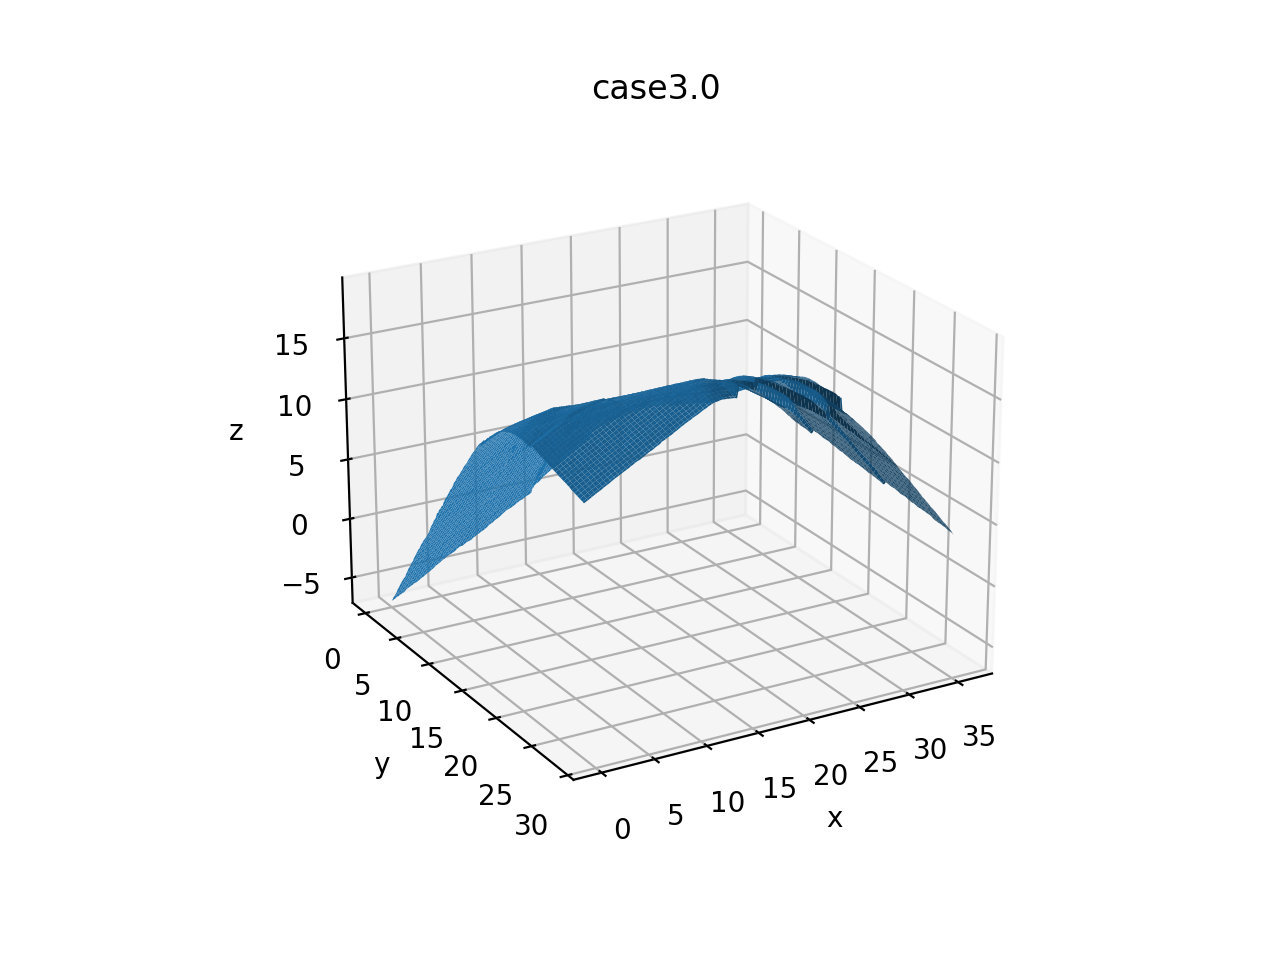

In [65]:
# Show the reconstructed surface
nx1tot = min(nx1list)
nx2tot = max(nx2list)
ny1tot = min(ny1list)
ny2tot = max(ny2list)
nxtot = nx2tot-nx1tot; print (nxtot)
nytot = ny2tot-ny1tot; print (nytot)
ymaxtot = (nytot-1)*dy; xmaxtot = (nxtot-1)*dx

surf_ytot = np.linspace(0,ymaxtot,nytot); #print surf_ytot[1]-surf_ytot[0]; 
surf_xtot = np.linspace(0,xmaxtot,nxtot); #print surf_xtot[1]-surf_xtot[0]; 
surf_xgridtot, surf_ygridtot = np.meshgrid(surf_xtot,surf_ytot)
settemp = solution[ny1tot:ny2tot,nx1tot:nx2tot]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(surf_xgridtot, surf_ygridtot, settemp, rstride=2,cstride=2)
ax.invert_yaxis() # invert y axis (this fixes the right-hand-oriented vs left-hand-oriented system)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title(imageroot)
ax.view_init(azim=-120,elev=22)

In [66]:
# Save this data

#save an image
fig.savefig(Retrievedjpgfile)


print("saving", Compressedfilename)
np.savez_compressed(Compressedfilename, \
                    surfaceroot=imageroot, \
                    imageroot=imageroot, \
                    nx1list=nx1list, \
                    nx2list=nx2list, \
                    ny1list=ny1list, \
                    ny2list=ny2list, \
                    pA=pA, \
                    pB=pB, \
                    pC=pC, \
                    pD=pD, \
                    sA=sA, \
                    sB=sB, \
                    sC=sC, \
                    sD=sD, \
                    nxi=nxi, \
                    nyi=nyi, \
                    dnx=dnx, \
                    dny=dny, \
                    solution=solution)

saving Segments_Calibration_retrieved
